In [14]:
from datetime import datetime
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import pandas as pd
import numpy as np
import re
from tqdm import tqdm
from cliff.api import Cliff
import seaborn as sns
from transformers import pipeline


# Data Preprocessing

## Dropping data with empty dates and sorting data by date

In [2]:
dataset = pd.read_json('random_c4.json').reset_index(drop = True)

In [3]:
dataset.head()

,text,timestamp,url
0,Cumberland County Prosecutor’s Office says rem...,2019-04-18 13:05:03,https://www.thedailyjournal.com/story/news/loc...
1,War? . . . what war?\nDoes it seem like we are...,2019-04-18 21:00:27,https://www.texasgopvote.com/war-what-war-00116
2,The Sagittarian Teapot (center of our Milky Wa...,2019-04-18 14:36:08,https://www.miamiherald.com/living/article2595...
3,Sportswear tycoon Mike Ashley gave orders to s...,2019-04-18 20:17:31,https://www.thisismoney.co.uk/money/markets/ar...
4,"Vice President Chen Chien-jen, second left, an...",2019-04-18 19:28:32,http://www.taipeitimes.com/News/front/archives...


In [ ]:
dataset['timestamp']= pd.to_datetime(dataset['timestamp'])

## Predicting subject country of each article

In [5]:
# Execute the following from command-line first before running this cell
# docker pull rahulbot/cliff-clavin:latest
# docker run -p 8080:8080 -m 8G -d rahulbot/cliff-clavin:latest

my_cliff = Cliff('http://localhost:8080')
dataset["geoparsed"] = [my_cliff.parse_text(x) for x in tqdm(dataset["text"])]

100%|██████████| 450000/450000 [2:51:40<00:00, 43.69it/s]


## Cleaning dataset
- Extract out info from cliff-clavin output

In [6]:
cities_list, states_list, countries_list, country_name, country_code = [], [], [], [], []
for x in tqdm(dataset['geoparsed']):
    if x['results']['places']['focus']:
        cities_list.append(x['results']['places']['focus']['cities'])
        states_list.append(x['results']['places']['focus']['states'])
        countries_list.append(x['results']['places']['focus']['countries'])
        tmp_country_name, tmp_country_code = [], []
        for country in x['results']['places']['focus']['countries']:
            tmp_country_name.append(country['name'])
            tmp_country_code.append(country['countryCode'])
        country_name.append(tmp_country_name)
        country_code.append(tmp_country_code)
    else:
        cities_list.append(None)
        states_list.append(None)
        countries_list.append(None)
        country_name.append(None)
        country_code.append(None)

100%|██████████| 450000/450000 [00:04<00:00, 90282.17it/s] 


In [7]:
dataset['cities_list'] = cities_list
dataset['states_list'] = states_list
dataset['countries_list'] = countries_list
dataset['country_name'] = country_name
dataset['country_code'] = country_code
dataset = dataset.drop(columns = 'geoparsed')

In [8]:
dataset.head()

,text,timestamp,url,cities_list,states_list,countries_list,country_name,country_code
0,Cumberland County Prosecutor’s Office says rem...,2019-04-18 13:05:03,https://www.thedailyjournal.com/story/news/loc...,"[{'score': 4, 'featureCode': 'PPL', 'stateGeoN...","[{'score': 9, 'featureCode': 'ADM1', 'stateGeo...","[{'score': 12, 'featureCode': 'PCLI', 'stateGe...",[United States],[US]
1,War? . . . what war?\nDoes it seem like we are...,2019-04-18 21:00:27,https://www.texasgopvote.com/war-what-war-00116,"[{'score': 1, 'featureCode': 'PPLA2', 'stateGe...","[{'score': 3, 'featureCode': 'ADM1', 'stateGeo...","[{'score': 3, 'featureCode': 'PCLI', 'stateGeo...",[United States],[US]
2,The Sagittarian Teapot (center of our Milky Wa...,2019-04-18 14:36:08,https://www.miamiherald.com/living/article2595...,"[{'score': 3, 'featureCode': 'PPLL', 'stateGeo...","[{'score': 4, 'featureCode': 'ADM1', 'stateGeo...","[{'score': 4, 'featureCode': 'PCLI', 'stateGeo...",[Commonwealth of Australia],[AU]
3,Sportswear tycoon Mike Ashley gave orders to s...,2019-04-18 20:17:31,https://www.thisismoney.co.uk/money/markets/ar...,"[{'score': 1, 'featureCode': 'PPLA2', 'stateGe...","[{'score': 1, 'featureCode': 'ADM1', 'stateGeo...","[{'score': 2, 'featureCode': 'PCLI', 'stateGeo...",[United Kingdom of Great Britain and Northern ...,[GB]
4,"Vice President Chen Chien-jen, second left, an...",2019-04-18 19:28:32,http://www.taipeitimes.com/News/front/archives...,"[{'score': 2, 'featureCode': 'PPLC', 'stateGeo...","[{'score': 2, 'featureCode': 'ADM1', 'stateGeo...","[{'score': 7, 'featureCode': 'PCLI', 'stateGeo...",[Taiwan],[TW]


In [9]:
dataset.to_json('c4_news_geoparsed.json')

# Extract out countries

In [4]:
dataset = pd.read_json('c4_news_geoparsed.json')

In [5]:
dataset['timestamp'] = pd.to_datetime(dataset['timestamp'])

In [6]:
# Check for number of rows with no countries assosociated: 68043 rows
no_country = dataset['countries_list'].isnull().sum()
old_rows = dataset.shape[0]
print("Number of articles with no countries detected: {}".format(no_country))
print("Percentage of articles with no countries detected: {:.2f}%".format(no_country/old_rows * 100))

Number of articles with no countries detected: 93943
Percentage of articles with no countries detected: 20.88%


In [7]:
# Drop rows with no country tagged; make sure no data lost
dataset = dataset.dropna(axis = 0, subset = ['countries_list'])
print(dataset.shape[0] == old_rows - no_country)
print("Number of articles left with countries detected: {}".format(dataset.shape[0]))

True
Number of articles left with countries detected: 356057


Text(0.5, 1.0, 'Distribution of articles with focus country')

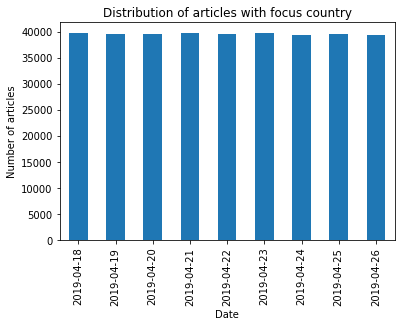

In [8]:
dataset['timestamp'].dt.date.value_counts().sort_index().plot(kind = 'bar')
plt.xlabel('Date')
plt.ylabel('Number of articles')
plt.title('Distribution of articles with focus country')

In [9]:
# For rows with more than 1 country, duplicate them such that each row only contains one country
dataset.rename(columns={'country_name': 'x', 'country_code': 'y'}, inplace=True)
dataset = dataset.explode(list('xy'))
dataset.rename(columns={'x': 'country_name', 'y': 'country_code'}, inplace=True)
dataset.tail()

,text,timestamp,url,cities_list,states_list,countries_list,country_name,country_code
449992,Marilyn Manson plans to release ‘DISPOSABLE TE...,2019-04-26 04:05:38,https://www.nme.com/news/music/marilyn-manson-...,"[{'score': 2, 'featureCode': 'PPLC', 'stateGeo...","[{'score': 2, 'featureCode': 'ADM1', 'stateGeo...","[{'score': 5, 'featureCode': 'PCLI', 'stateGeo...",United Kingdom of Great Britain and Northern I...,GB
449994,LONDON (Reuters) - Core euro zone bond yields ...,2019-04-26 10:00:27,https://uk.reuters.com/article/us-eurozone-bon...,"[{'score': 2, 'featureCode': 'PPLC', 'stateGeo...","[{'score': 2, 'featureCode': 'ADM1', 'stateGeo...","[{'score': 2, 'featureCode': 'PCLI', 'stateGeo...",United Kingdom of Great Britain and Northern I...,GB
449997,"The University of California, Davis has conduc...",2019-04-26 05:39:44,https://tahoe.ucdavis.edu/stateofthelake,"[{'score': 8, 'featureCode': 'PPL', 'stateGeoN...","[{'score': 9, 'featureCode': 'ADM1', 'stateGeo...","[{'score': 14, 'featureCode': 'PCLI', 'stateGe...",United States,US
449998,KARACHI: Government ban on power generation fr...,2019-04-26 14:24:23,https://www.thenews.com.pk/print/163881-Ban-on...,"[{'score': 1, 'featureCode': 'PPLA', 'stateGeo...","[{'score': 2, 'featureCode': 'ADM1', 'stateGeo...","[{'score': 2, 'featureCode': 'PCLI', 'stateGeo...",Islamic Republic of Pakistan,PK
449999,SEATTLE — The University of Colorado football ...,2019-04-26 13:38:38,https://kdvr.com/2018/10/19/cu-looks-to-bounce...,"[{'score': 2, 'featureCode': 'PPLA2', 'stateGe...","[{'score': 3, 'featureCode': 'ADM1', 'stateGeo...","[{'score': 8, 'featureCode': 'PCLI', 'stateGeo...",United States,US


In [10]:
country_count = dataset['country_code'].value_counts(dropna=False)
country_count.to_json('C4 News Total Country Counts.json')

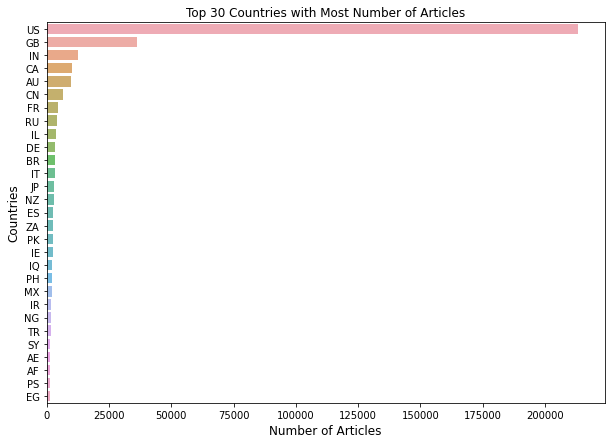

In [11]:
country_count = country_count[:30,]
plt.figure(figsize=(10,7))
sns.barplot(y = country_count.index, x= country_count.values, alpha=0.8)
plt.title('Top 30 Countries with Most Number of Articles')
plt.xlabel('Number of Articles', fontsize=12)
plt.ylabel('Countries', fontsize=12)
# plt.grid()
plt.show()

In [12]:
dataset.head()

,text,timestamp,url,cities_list,states_list,countries_list,country_name,country_code
0,Cumberland County Prosecutor’s Office says rem...,2019-04-18 13:05:03,https://www.thedailyjournal.com/story/news/loc...,"[{'score': 4, 'featureCode': 'PPL', 'stateGeoN...","[{'score': 9, 'featureCode': 'ADM1', 'stateGeo...","[{'score': 12, 'featureCode': 'PCLI', 'stateGe...",United States,US
1,War? . . . what war?\nDoes it seem like we are...,2019-04-18 21:00:27,https://www.texasgopvote.com/war-what-war-00116,"[{'score': 1, 'featureCode': 'PPLA2', 'stateGe...","[{'score': 3, 'featureCode': 'ADM1', 'stateGeo...","[{'score': 3, 'featureCode': 'PCLI', 'stateGeo...",United States,US
2,The Sagittarian Teapot (center of our Milky Wa...,2019-04-18 14:36:08,https://www.miamiherald.com/living/article2595...,"[{'score': 3, 'featureCode': 'PPLL', 'stateGeo...","[{'score': 4, 'featureCode': 'ADM1', 'stateGeo...","[{'score': 4, 'featureCode': 'PCLI', 'stateGeo...",Commonwealth of Australia,AU
3,Sportswear tycoon Mike Ashley gave orders to s...,2019-04-18 20:17:31,https://www.thisismoney.co.uk/money/markets/ar...,"[{'score': 1, 'featureCode': 'PPLA2', 'stateGe...","[{'score': 1, 'featureCode': 'ADM1', 'stateGeo...","[{'score': 2, 'featureCode': 'PCLI', 'stateGeo...",United Kingdom of Great Britain and Northern I...,GB
4,"Vice President Chen Chien-jen, second left, an...",2019-04-18 19:28:32,http://www.taipeitimes.com/News/front/archives...,"[{'score': 2, 'featureCode': 'PPLC', 'stateGeo...","[{'score': 2, 'featureCode': 'ADM1', 'stateGeo...","[{'score': 7, 'featureCode': 'PCLI', 'stateGeo...",Taiwan,TW


# Splitting into buckets for countries of interest

In [13]:
countries_of_interest = ['US', 'GB', 'IN']

for country in countries_of_interest:
    tmp = dataset[dataset['country_code'] == country]
    tmp.to_json('c4_' + country+ '.json')
    print("Total number of articles for {}: {}".format(country, tmp.shape[0]))


Total number of articles for US: 213331
Total number of articles for GB: 36150
Total number of articles for IN: 12466
